# Tutorial 2: Training a spiking neural network on a simple vision dataset

Friedemann Zenke (https://fzenke.net)

> For more details on surrogate gradient learning, please see: 
> Neftci, E.O., Mostafa, H., and Zenke, F. (2019). Surrogate Gradient Learning in Spiking Neural Networks.
> https://arxiv.org/abs/1901.09948

In Tutorial 1, we have seen how to train a simple multi-layer spiking neural network on a small synthetic dataset. In this tutorial, we will apply what we have learned so far to a slightly larger dataset. Concretely, we will use the Fashion MNIST dataset.

In [181]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns

import torch
import torch.nn as nn
import torchvision

In [182]:
torch.__version__

'1.8.1+cpu'

In [183]:
# The coarse network structure is dicated by the Fashion MNIST dataset. 
nb_inputs  = 28*28
nb_hidden  = 100
nb_outputs = 10

time_step = 1e-3
nb_steps  = 100

batch_size = 256

In [184]:
dtype = torch.float

# Check whether a GPU is available
if torch.cuda.is_available():
    device = torch.device("cuda")     
else:
    device = torch.device("cpu")

In [185]:
# Here we load the Dataset
root = os.path.expanduser("~/data/datasets/torch/fashion-mnist")
train_dataset = torchvision.datasets.FashionMNIST(root, train=True, transform=None, target_transform=None, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root, train=False, transform=None, target_transform=None, download=True)

In [186]:
# Standardize data
# x_train = torch.tensor(train_dataset.train_data, device=device, dtype=dtype)
x_train = np.array(train_dataset.data, dtype=np.float)
x_train = x_train.reshape(x_train.shape[0],-1)/255
# x_test = torch.tensor(test_dataset.test_data, device=device, dtype=dtype)
x_test = np.array(test_dataset.data, dtype=np.float)
x_test = x_test.reshape(x_test.shape[0],-1)/255

# y_train = torch.tensor(train_dataset.train_labels, device=device, dtype=dtype)
# y_test  = torch.tensor(test_dataset.test_labels, device=device, dtype=dtype)
y_train = np.array(train_dataset.targets, dtype=np.int)
y_test  = np.array(test_dataset.targets, dtype=np.int)

(-0.5, 27.5, 27.5, -0.5)

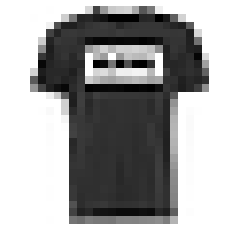

In [187]:
# Here we plot one of the raw data points as an example 
data_id = 1
plt.imshow(x_train[data_id].reshape(28,28), cmap=plt.cm.gray_r)
plt.axis("off")

Since we are working with spiking neural networks, we ideally want to use a temporal code to make use of spike timing. To that end, we will use a spike latency code to feed spikes to our network.

In [188]:
def current2firing_time(x, tau=20, thr=0.2, tmax=1.0, epsilon=1e-7):
    """ Computes first firing time latency for a current input x assuming the charge time of a current based LIF neuron.

    Args:
    x -- The "current" values

    Keyword args:
    tau -- The membrane time constant of the LIF neuron to be charged
    thr -- The firing threshold value 
    tmax -- The maximum time returned 
    epsilon -- A generic (small) epsilon > 0

    Returns:
    Time to first spike for each "current" x
    """
    idx = x<thr
    x = np.clip(x,thr+epsilon,1e9)
    T = tau*np.log(x/(x-thr))
    T[idx] = tmax
    return T
 

def sparse_data_generator(X, y, batch_size, nb_steps, nb_units, shuffle=True ):
    """ This generator takes datasets in analog format and generates spiking network input as sparse tensors. 

    Args:
        X: The data ( sample x event x 2 ) the last dim holds (time,neuron) tuples
        y: The labels
    """

    labels_ = np.array(y,dtype=np.int)
    number_of_batches = len(X)//batch_size
    sample_index = np.arange(len(X))

    # compute discrete firing times
    tau_eff = 20e-3/time_step
    firing_times = np.array(current2firing_time(X, tau=tau_eff, tmax=nb_steps), dtype=np.int)
    unit_numbers = np.arange(nb_units)

    if shuffle:
        np.random.shuffle(sample_index)

    total_batch_count = 0
    counter = 0
    while counter<number_of_batches:
        batch_index = sample_index[batch_size*counter:batch_size*(counter+1)]

        coo = [ [] for i in range(3) ]
        for bc,idx in enumerate(batch_index):
            c = firing_times[idx]<nb_steps
            times, units = firing_times[idx][c], unit_numbers[c]

            batch = [bc for _ in range(len(times))]
            coo[0].extend(batch)
            coo[1].extend(times)
            coo[2].extend(units)

        i = torch.LongTensor(coo).to(device)
        v = torch.FloatTensor(np.ones(len(coo[0]))).to(device)
    
        X_batch = torch.sparse.FloatTensor(i, v, torch.Size([batch_size,nb_steps,nb_units])).to(device)
        y_batch = torch.tensor(labels_[batch_index],device=device)

        yield X_batch.to(device=device), y_batch.to(device=device)

        counter += 1

##  Setup of the spiking network model 

In [189]:
tau_mem = 10e-3
tau_syn = 5e-3

alpha   = float(np.exp(-time_step/tau_syn))
beta    = float(np.exp(-time_step/tau_mem))

In [190]:
weight_scale = 7*(1.0-beta) # this should give us some spikes to begin with

w1 = torch.empty((nb_inputs, nb_hidden),  device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w1, mean=0.0, std=weight_scale/np.sqrt(nb_inputs))

w2 = torch.empty((nb_hidden, nb_outputs), device=device, dtype=dtype, requires_grad=True)
torch.nn.init.normal_(w2, mean=0.0, std=weight_scale/np.sqrt(nb_hidden))

print("init done")

init done


In [191]:
def plot_voltage_traces(mem, spk=None, dim=(3,5), spike_height=50):
    gs=GridSpec(*dim)
    if spk is not None:
        dat = 1.0*mem
        dat[spk>0.0] = spike_height
        dat = dat.detach().cpu().numpy()
    else:
        dat = mem.detach().cpu().numpy()
    for i in range(np.prod(dim)):
        if i==0: a0=ax=plt.subplot(gs[i])
        else: ax=plt.subplot(gs[i],sharey=a0)
        ax.plot(dat[i])
        ax.axis("off")

## Training the Network

In [192]:
class SurrGradSpike(torch.autograd.Function):
    """
    Here we implement our spiking nonlinearity which also implements 
    the surrogate gradient. By subclassing torch.autograd.Function, 
    we will be able to use all of PyTorch's autograd functionality.
    Here we use the normalized negative part of a fast sigmoid 
    as this was done in Zenke & Ganguli (2018).
    """
    
    scale = 100.0 # controls steepness of surrogate gradient

    @staticmethod
    def forward(ctx, input):
        """
        In the forward pass we compute a step function of the input Tensor
        and return it. ctx is a context object that we use to stash information which 
        we need to later backpropagate our error signals. To achieve this we use the 
        ctx.save_for_backward method.
        """
        ctx.save_for_backward(input)
        out = torch.zeros_like(input)
        out[input > 0] = 1.0
        return out

    @staticmethod
    def backward(ctx, grad_output):
        """
        In the backward pass we receive a Tensor we need to compute the 
        surrogate gradient of the loss with respect to the input. 
        Here we use the normalized negative part of a fast sigmoid 
        as this was done in Zenke & Ganguli (2018).
        """
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad = grad_input/(SurrGradSpike.scale*torch.abs(input)+1.0)**2
        return grad
    
# here we overwrite our naive spike function by the "SurrGradSpike" nonlinearity which implements a surrogate gradient
spike_fn  = SurrGradSpike.apply

In [193]:
def run_snn(inputs):
    h1 = torch.einsum("abc,cd->abd", (inputs, w1))
    dendrite = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)
    soma = torch.zeros((batch_size,nb_hidden), device=device, dtype=dtype)

    # Here we define two lists which we use to record the membrane potentials and output spikes
    dendrite_rec = []
    dendrite_nl_rec = []
    soma_rec = []
    spk_rec = []

    soma_thresh = 15
    gamma = 0.05
    dend_thresh = 0.2
    sig_sensitivity = 10
    sig_gain = 5
    
    # Here we loop over time
    for t in range(nb_steps):
        soma_over_thresh = soma - soma_thresh
        out = spike_fn(soma_over_thresh)
        reset = out.detach() # We do not want to backprop through the reset

        sig = torch.nn.Sigmoid()

        new_dendrite = alpha*dendrite + h1[:,t] + gamma * reset
        dendrite_nl = sig_gain * sig(sig_sensitivity*(dendrite - dend_thresh)) + dendrite
        new_soma = (beta*soma + dendrite_nl)*(1.0 - reset)
        
        soma_rec.append(soma)
        dendrite_rec.append(dendrite)
        dendrite_nl_rec.append(dendrite_nl)
        spk_rec.append(out)
        
        dendrite = new_dendrite
        soma = new_soma

    dendrite_rec = torch.stack(dendrite_rec,dim=1)
    dendrite_nl_rec = torch.stack(dendrite_nl_rec,dim=1)
    soma_rec = torch.stack(soma_rec,dim=1)
    spk_rec = torch.stack(spk_rec,dim=1)

    # Readout layer
    h2= torch.einsum("abc,cd->abd", (spk_rec, w2))
    flt = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out = torch.zeros((batch_size,nb_outputs), device=device, dtype=dtype)
    out_rec = [out]
    for t in range(nb_steps):
        new_flt = alpha*flt +h2[:,t]
        new_out = beta*out +flt

        flt = new_flt
        out = new_out

        out_rec.append(out)

    out_rec = torch.stack(out_rec,dim=1)
    other_recs = [soma_rec, spk_rec]
    return out_rec, other_recs

In [194]:
def train(x_data, y_data, lr=2e-3, nb_epochs=10):
    params = [w1,w2]
    optimizer = torch.optim.Adam(params, lr=lr, betas=(0.9,0.999))

    log_softmax_fn = nn.LogSoftmax(dim=1)
    loss_fn = nn.NLLLoss()
    
    loss_hist = []
    for e in range(nb_epochs):
        local_loss = []
        for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs):
            output,_ = run_snn(x_local.to_dense())
            m,_=torch.max(output,1)
            log_p_y = log_softmax_fn(m)
            loss_val = loss_fn(log_p_y, y_local.long())

            optimizer.zero_grad()
            loss_val.backward()
            optimizer.step()
            local_loss.append(loss_val.item())
        mean_loss = np.mean(local_loss)
        print("Epoch %i: loss=%.5f"%(e+1,mean_loss))
        loss_hist.append(mean_loss)
        
    return loss_hist
        
        
def compute_classification_accuracy(x_data, y_data):
    """ Computes classification accuracy on supplied data in batches. """
    accs = []
    for x_local, y_local in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=False):
        output,_ = run_snn(x_local.to_dense())
        m,_= torch.max(output,1) # max over time
        _,am=torch.max(m,1)      # argmax over output units
        tmp = np.mean((y_local==am).detach().cpu().numpy()) # compare to labels
        accs.append(tmp)
    return np.mean(accs)

In [195]:
loss_hist = train(x_train, y_train, lr=2e-4, nb_epochs=30)

Epoch 1: loss=1.18126
Epoch 2: loss=0.67224
Epoch 3: loss=0.60065
Epoch 4: loss=0.56560
Epoch 5: loss=0.54238
Epoch 6: loss=0.53439
Epoch 7: loss=0.52493
Epoch 8: loss=0.50974
Epoch 9: loss=0.49781
Epoch 10: loss=0.48946
Epoch 11: loss=0.47565
Epoch 12: loss=0.47420
Epoch 13: loss=0.46975
Epoch 14: loss=0.47097
Epoch 15: loss=0.46758
Epoch 16: loss=0.46150
Epoch 17: loss=0.45322
Epoch 18: loss=0.44969
Epoch 19: loss=0.45089
Epoch 20: loss=0.44255
Epoch 21: loss=0.43710
Epoch 22: loss=0.43950
Epoch 23: loss=0.43177
Epoch 24: loss=0.42798
Epoch 25: loss=0.43095
Epoch 26: loss=0.42001
Epoch 27: loss=0.42017
Epoch 28: loss=0.42321
Epoch 29: loss=0.41791
Epoch 30: loss=0.41247


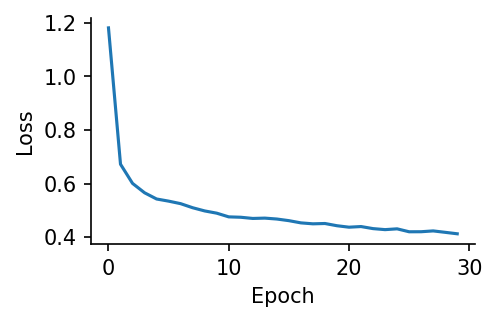

In [196]:
plt.figure(figsize=(3.3,2),dpi=150)
plt.plot(loss_hist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
sns.despine()

In [197]:
print("Training accuracy: %.3f"%(compute_classification_accuracy(x_train,y_train)))
print("Test accuracy: %.3f"%(compute_classification_accuracy(x_test,y_test)))

Training accuracy: 0.850
Test accuracy: 0.830


In [198]:
def get_mini_batch(x_data, y_data, shuffle=False):
    for ret in sparse_data_generator(x_data, y_data, batch_size, nb_steps, nb_inputs, shuffle=shuffle):
        return ret

In [199]:
x_batch, y_batch = get_mini_batch(x_test, y_test)
output, other_recordings = run_snn(x_batch.to_dense())
soma_rec, spk_rec = other_recordings

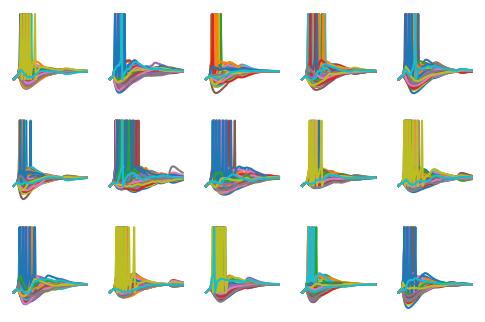

In [200]:
fig=plt.figure(dpi=100)
plot_voltage_traces(soma_rec, spk_rec)

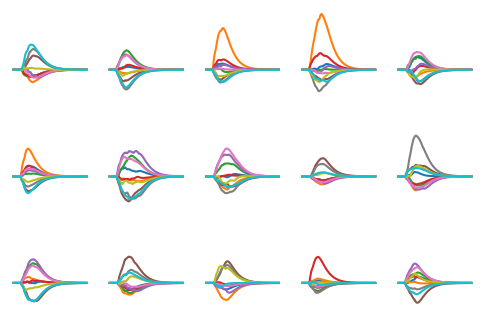

In [201]:
fig=plt.figure(dpi=100)
plot_voltage_traces(output)

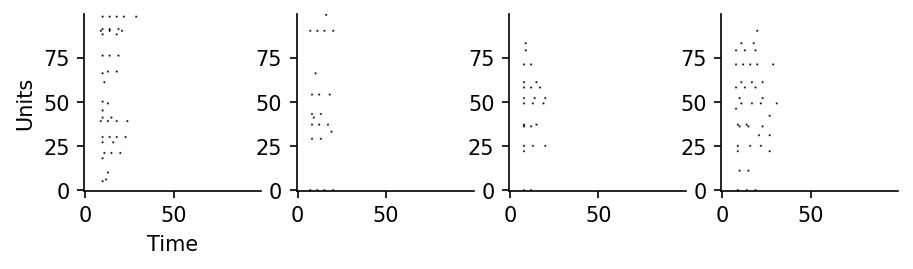

In [202]:
nb_plt = 4
gs = GridSpec(1,nb_plt)
fig= plt.figure(figsize=(7,3),dpi=150)
for i in range(nb_plt):
    plt.subplot(gs[i])
    plt.imshow(spk_rec[i].detach().cpu().numpy().T,cmap=plt.cm.gray_r, origin="lower" )
    if i==0:
        plt.xlabel("Time")
        plt.ylabel("Units")

    sns.despine()